# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [ ]:
import torch
from model import LeNet5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

model = LeNet5()
model.load_state_dict(torch.load('LeNet5_weights.pkl', weights_only=True))
model = model.to(device)
model.eval()

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt



transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [ ]:
def dreamingLeNet5(lambda_l2=0):
    imgs = torch.randn(10, 1, 28, 28, requires_grad=True)
    imgs = imgs.to(device).clone().detach().requires_grad_()
    targets = torch.arange(10).to(device)

    model.eval()
    optimizer = torch.optim.Adam([imgs], lr=0.05)


    for step in range(1000):
        optimizer.zero_grad()

        batch_outputs = (model(imgs)).to(device)

        loss1 = -torch.nn.functional.cross_entropy(batch_outputs, targets) 
        loss2 = lambda_l2 * imgs.pow(2).mean()
        loss = -loss1 + loss2

        loss.backward()
        optimizer.step()
        imgs.data.clamp_(-1.5, 1.5)

        if step % 100 == 0:
            print(f"Step {step}, Loss: {-loss.item():.4f}")


    # Visualisation
    with torch.no_grad():
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(imgs[i][0].detach().cpu())
            plt.title(f"Digit {i}")
            plt.axis("off")

        # fig.suptitle(f"Regularization $\\lambda$ = {lambda_l2}")
        plt.tight_layout()
        plt.show()

In [ ]:
print("Dreaming without penalization (LeNet5)")
dreamingLeNet5()

print("Dreaming with different penalization parameter lambda")
lambda_l2 = 0.001

for i in range(5):
    dreamingLeNet5(lambda_l2=lambda_l2 * (10 ** i))   #Penalization 

# TASK 2 - LEARNING NOISE

Here im just experimenting with noise

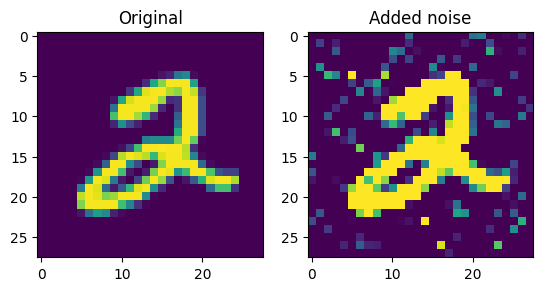

In [ ]:
def add_noise(img, mean=0.0, std=0.5, noise_coef = 2):
    if img.ndim == 3:
        img = img.squeeze(0)

    noise = torch.randn_like(img) * std
    noise = noise * (0.5 - img) * noise_coef
    # plt.imshow(noise)
    
    noisy_img = torch.clamp(img + noise, 0.0, 1.0)
    return noisy_img


train_image, train_target = trainset[5]
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(train_image.squeeze())

noisy_image = add_noise(train_image, noise_coef=1)
plt.subplot(1,2,2)
plt.title("Added noise")
plt.imshow(noisy_image.squeeze())
plt.show()              

Step 0, Loss: -8.0599
Step 100, Loss: -0.0050
Step 200, Loss: -0.0046
Step 300, Loss: -0.0043
Step 400, Loss: -0.0039
Step 500, Loss: -0.0036
Step 600, Loss: -0.0034
Step 700, Loss: -0.0032
Step 800, Loss: -0.0030
Step 900, Loss: -0.0028


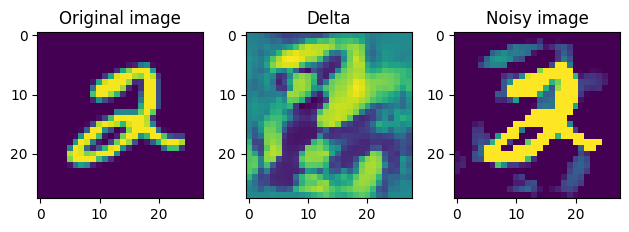

In [ ]:
def learning_noise(lambda_l2=0):

    train_image, train_target = trainset[5]
    train_image = train_image.to(device)
    train_target = torch.tensor(train_target).to(device)
    wrong_target = (train_target + 1) % 10

    delta = torch.zeros_like(train_image, requires_grad=True, device=device)
    

    model.eval()
    optimizer = torch.optim.Adam([delta], lr=0.05)


    for step in range(1000):
        optimizer.zero_grad()

        perturbed_img = (train_image + delta).unsqueeze(0).to(device)
        output = model(perturbed_img)

        target_wrong_tensor = torch.tensor([wrong_target], device=device)
        loss1 = torch.nn.functional.cross_entropy(output, target_wrong_tensor)
        loss2 = lambda_l2 * delta.pow(2).mean()
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        delta.data.clamp_(-1, 1)

        if step % 100 == 0:
            print(f"Step {step}, Loss: {-loss.item():.4f}")


    # Visualisation
    with torch.no_grad():
        perturbed_img = (train_image + delta).clamp(0, 1)
        plt.subplot(1,3,1)
        plt.title("Original image")
        plt.imshow(train_image.squeeze(0).cpu())

        plt.subplot(1,3,2)
        plt.title("Delta")
        plt.imshow(delta.squeeze(0).cpu())

        plt.subplot(1,3,3)
        plt.title("Noisy image")
        plt.imshow(perturbed_img.squeeze(0).cpu())

        plt.tight_layout()
        plt.show()    
    return perturbed_img

perturbed_img = learning_noise(lambda_l2=0.01)

In [72]:
model.eval()

with torch.no_grad():  
        pred_clean = model(train_image.unsqueeze(0).to(device))
        pred_noisy = model(perturbed_img.unsqueeze(0).to(device))

        print("Clean prediction:", torch.argmax(pred_clean).item())
        print("Noisy prediction:", torch.argmax(pred_noisy).item())

Clean prediction: 2
Noisy prediction: 3
